# EDA

#### Reading in Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

test = pd.read_csv('./data/testing_data.csv')
train = pd.read_csv('./data/training_data.csv')

# Dropping row number and 'id' columns
test = test.drop(columns=['Unnamed: 0','id'])
train = train.drop(columns=['Unnamed: 0','id'])

# Renaming residence_type to make capitalization uniform
test = test.rename(columns={'Residence_type':'residence_type'})
train = train.rename(columns={'Residence_type':'residence_type'})

In [2]:
train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,36.0,0,0,Yes,Govt_job,Urban,65.87,32.2,formerly smoked,0
1,Female,45.0,0,0,Yes,Govt_job,Rural,68.66,25.3,never smoked,0
2,Male,58.0,0,0,No,Self-employed,Rural,170.93,30.7,Unknown,0
3,Female,61.0,0,0,Yes,Self-employed,Urban,69.88,27.1,never smoked,0
4,Female,78.0,0,0,No,Private,Urban,103.86,30.6,Unknown,0


In [3]:
# Finding NaNs in train, test
print(train.isna().sum().sum())
print(test.isna().sum().sum())

# Dropping NaNs, all of which occur in bmi
train['bmi'] = train['bmi'].fillna(train['bmi'].mean())
test['bmi'] = test['bmi'].fillna(test['bmi'].mean())

print(train.isna().sum().sum())
print(test.isna().sum().sum())

159
42
0
0


Rows for NaN values in bmi are imputed with the mean. As seen later, bmi is not strongly correlated with stroke, so making the assumption that the missing bmi's are average likely won't negatively affect model performance (as bmi likely won't be the most influential variable). Though the rows are not dropped, as they could hold other data which are important

#### Summary Data

Numeric variables: age, hypertension, heart_disease, avg_glucose_level, bmi

Categorical variables: gender, ever_married, work_type, residence_type, smoking_status

In [4]:
numerics = ['age','hypertension','heart_disease','avg_glucose_level','bmi','stroke']
cats = ['gender','ever_married','work_type','residence_type','smoking_status'] # cats!

(train[numerics]).describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,43.324169,0.097871,0.056031,106.010396,28.923371,0.048691
std,22.531019,0.297177,0.230010,45.047912,7.688969,0.215248
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,77.295000,23.900000,0.000000
50%,45.000000,0.000000,0.000000,92.000000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,113.845000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


#### Density plots of Numeric Variables

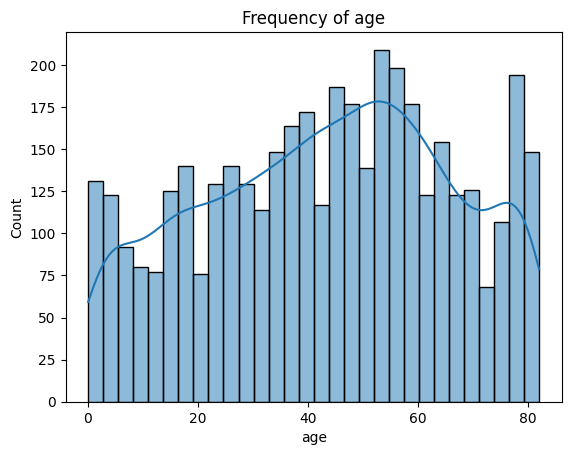

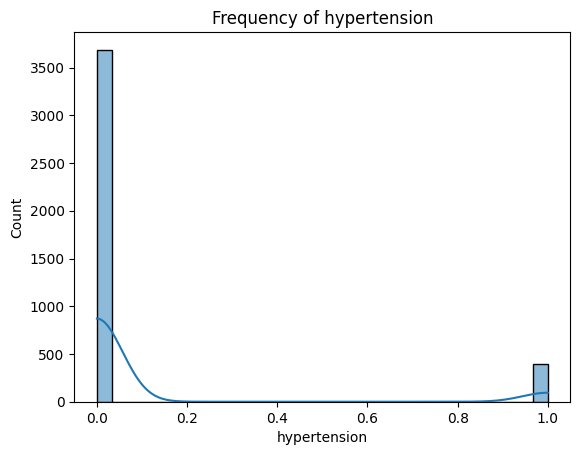

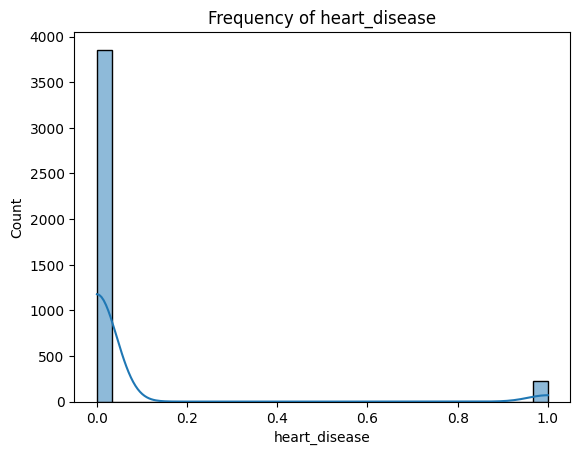

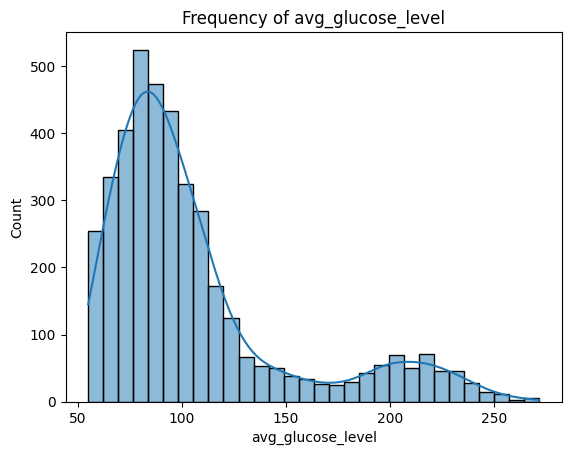

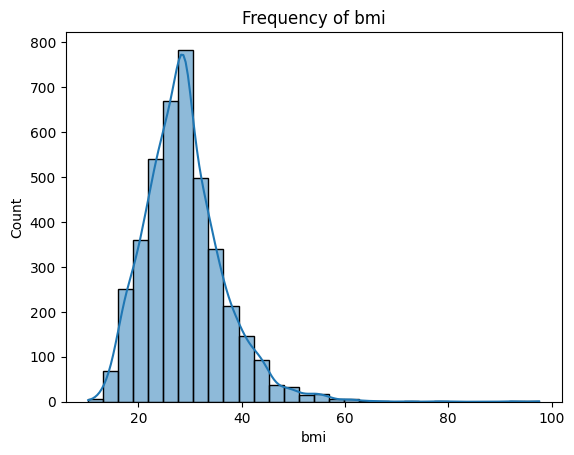

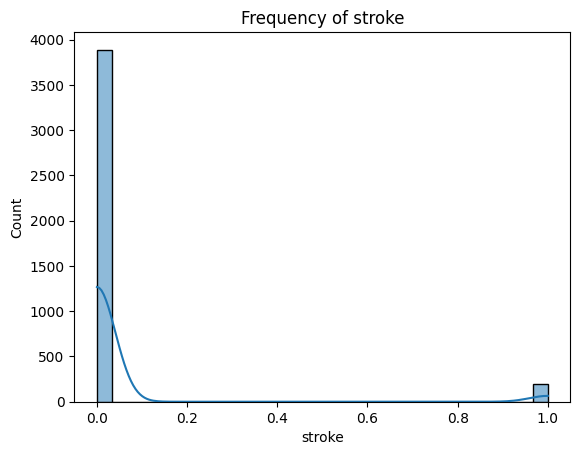

In [5]:
for var in numerics:
    sns.histplot(train[var],kde=True,bins=30)
    plt.title(f'Frequency of {var}')
    plt.show()

#### Bar Charts of Categorical Variables

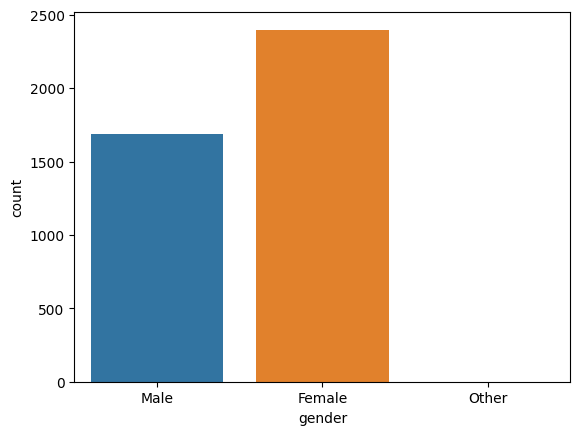

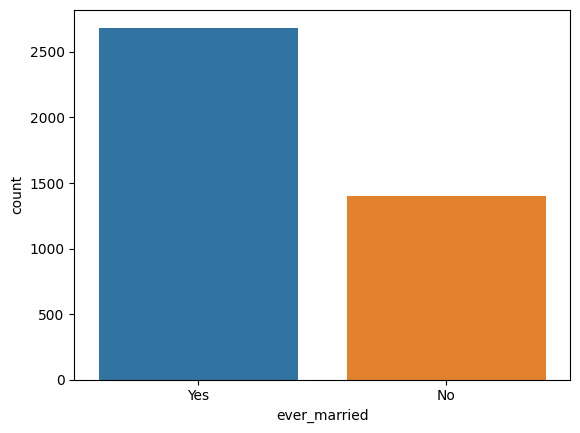

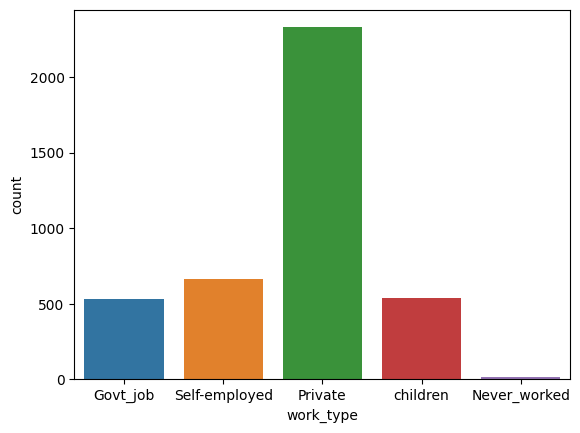

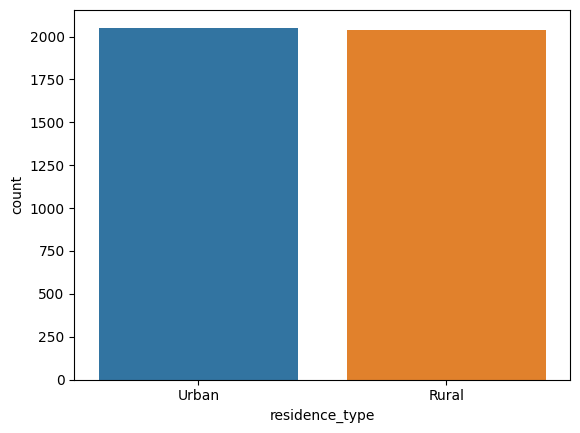

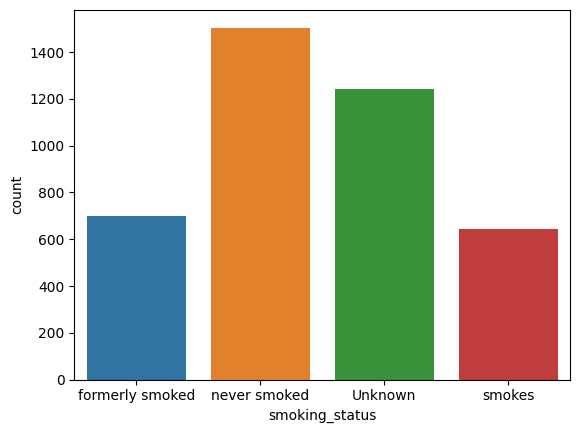

In [6]:
for var in cats:
    sns.countplot(x=var,data=train)
    plt.show()

#### Correlation Matrix of Numeric Variables

Text(0.5, 1.0, 'Correlation Matrix of Numeric Variables')

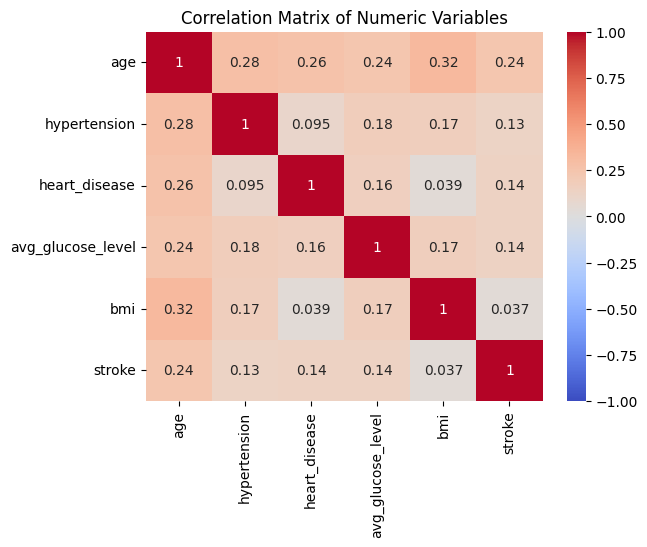

In [7]:
corr_matrix = train[numerics].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numeric Variables")

#### One-hot Encoding of Categoricals

In [8]:
train_cats = pd.get_dummies(train[cats])
train_cats['stroke'] = train['stroke']

#### Correlations of Categoricals

In [9]:
corr_matrix = train_cats.corr()
corr_matrix['stroke']

gender_Female                    -0.010992
gender_Male                       0.011105
gender_Other                     -0.003539
ever_married_No                  -0.098721
ever_married_Yes                  0.098721
work_type_Govt_job                0.006743
work_type_Never_worked           -0.013731
work_type_Private                 0.012856
work_type_Self-employed           0.053908
work_type_children               -0.081758
residence_type_Rural             -0.011565
residence_type_Urban              0.011565
smoking_status_Unknown           -0.057916
smoking_status_formerly smoked    0.060280
smoking_status_never smoked      -0.005374
smoking_status_smokes             0.017935
stroke                            1.000000
Name: stroke, dtype: float64

#### Feature Scaling

Function for normalizing the data, consideration of log/arcsing scaling in context of the variables, and polynomial features for numerical data

<Axes: xlabel='log_glucose', ylabel='Density'>

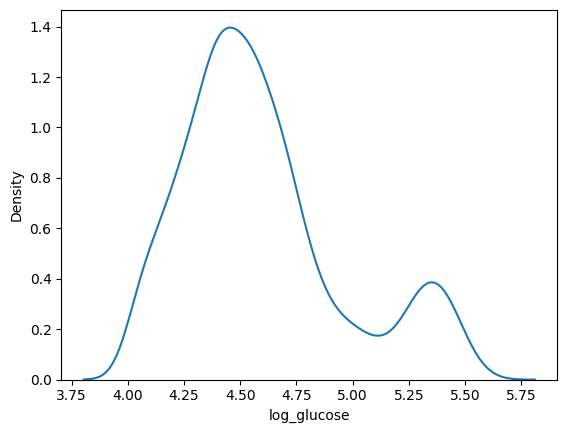

In [10]:
# Function to normalize data
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Of all the variables, the one with the most interesting potential for log is glucose level
train['log_glucose'] = np.log(train['avg_glucose_level'])
sns.kdeplot(data=train,x='log_glucose')

#### Variable Selection for Models

This section gives general ideas about feature selections, as well as a 'most general' version of the dataset (numeric features are normalized, log scaled variables and their original counterpart are included, as well as polynomial expansion of numeric variables, and one-hot encoding)

For variable selection, the following variables are the most promising for predicting stroke:
1. age - correlates most strongly with stroke
2. hypertension - decent correlation with stroke, though also correlates with age and could be redundant because of this
3. heart disease - decent correlation with stroke, but only a small proportion of the dataset have heart disease
4. glucose / log glucose - correlates somewhat with stroke, it is continuous numeric, so could have more say in classification, and the performance of the model with or without log scaled glucose could be interesting
5. ever married - the two answers to this question have opposite correlations, which could make it a powerful predictor.
6. work type - particulary in self-employed, or stay at home cases, there is correlation
7. smoking status - those who have smoked or do smoke have positive correlation with stroke
Others:
1. bmi - BMI does not strongly correlate with stroke, though since it is continous, it could be useful for providing more information than the strictly 1-0 other variables.
2. gender - gender doesn't really have any strong correlations, and is fairly evenly split.
3. residence_type - also evenly split, and doesn't seem to correlate with stroke.

Some combination, though likely not all 7, of these variables may be able to predict stroke well. One combination I think could work well (source: it came to me in a dream) is age, glucose OR log_glocuse, ever married, smoking status, and maybe 1 other variable

In [11]:
# Most general dataset with all features
from sklearn.preprocessing import PolynomialFeatures

numerics = ['age','hypertension','heart_disease','avg_glucose_level','bmi']
cats = ['gender','ever_married','work_type','residence_type','smoking_status'] # cats!

ytest = test['stroke']
ytrain = train['stroke']

test = test.drop(columns='stroke')
train = train.drop(columns='stroke')

# Get dummies for categoricals
train_cats = pd.get_dummies(train[cats])
test_cats = pd.get_dummies(test[cats])

# Polynomial features
def polyfeatures(data):
    expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
    Z = expander.fit_transform(data[numerics]) # Pass the df into the expander to get powers/interactions of x and y
    names = expander.get_feature_names_out() # Get the names of these variables
    zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
    return names, zdf

# To access 
trainPolyNames, trainPoly = polyfeatures(train)
testPolyNames, testPoly = polyfeatures(test)

# Log scaling
train['log_glucose'] = np.log(train['avg_glucose_level'])
test['log_glucose'] = np.log(test['avg_glucose_level'])

In [12]:
#poly names
poly_names = ['age^2', 'age hypertension', 'age heart_disease', 'age avg_glucose_level', 'age bmi', 'hypertension^2','hypertension heart_disease', 'hypertension avg_glucose_level','hypertension bmi', 'heart_disease^2','heart_disease avg_glucose_level', 'heart_disease bmi','avg_glucose_level^2', 'avg_glucose_level bmi', 'bmi^2']
numerics = ['age','hypertension','heart_disease','avg_glucose_level', 'bmi']

# Combining data to be exported
Xtest = test
Xtest = Xtest[numerics].apply(maxmin)
Xtest = pd.concat([Xtest, test['log_glucose'], test_cats, ytest],axis=1)
Xtest_3 = pd.concat([Xtest, test['log_glucose'], test_cats, testPoly[poly_names], ytest],axis=1)

Xtrain = train
Xtrain = Xtrain[numerics].apply(maxmin)
Xtrain = pd.concat([Xtrain, train['log_glucose'], train_cats, ytrain],axis=1)
Xtrain_3 = pd.concat([Xtrain, train['log_glucose'], train_cats, trainPoly[poly_names], ytrain],axis=1)

#make column number consistent
Xtest['gender_Other'] = 0
col = Xtest.pop('gender_Other')
Xtest.insert(8, 'gender_Other', col)

From here, polynomial features can easily be added and variables can be manipulated. Note that currently both log glucose and glucose are present, that the numeric features have been scaled, and that dummy variables are included

In [ ]:
Xtrain.to_csv('c_train.csv')
Xtest.to_csv('c_test.csv')

Xtrain_3.to_csv('c_train_deg3.csv')
Xtest_3.to_csv('c_test_deg3.csv')